<a href="https://colab.research.google.com/github/Mboubaker/Lidar_Evidential_occupancy_grid_mapping-/blob/main/FusionDST_Jaguar_Segway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implémentation d'une approche de fusion centralisée adaptée des différentes cartes locales des agents à partir des données Lidar issues de chaque agent**

Dans le cadre de la perception collaborative entre agents autonomes pour la modélisation de l'occupation, les approches de fusion de données reposent généralement sur :  La théorie des probabilités  et Les approches de fusion évidentielle

- ***Les approches de fusion évidentielle***

Dans le contexte de la fusion de grilles d'occupation évidentielles, les approches de fusion évidentielle sont des méthodes utilisées pour combiner les informations provenant de différentes sources afin de construire une représentation plus précise et complète de l'environnement. La fusion évidentielle vise à intégrer les données incertaines provenant de multiples capteurs ou sources pour obtenir une estimation plus fiable de l'état de l'environnement.

- **Opérateurs de combinaison :**

**Fusion conjonctive** : L’opérateur de fusion conjonctive permet de fusionner deux
fonctions de masse indépendantes définies sur le même cadre de discernement. Cet
opérateur de fusion fait l’hypothèse que toutes les sources sont fiables. Il permet
d’obtenir une fonction de masse plus informative que les deux sources. Il est très
similaire à l’opérateur intersection (∩) dans la théorie des ensembles.


**Fusion de Dempster** : L’opérateur de fusion de Dempster est un opérateur introduit par Dempster. C’est l’opérateur de référence qui est utilisé dans le domaine des fonction de croyance. La règle de fusion de Dempster est
réalisée en deux étapes : la fusion conjonctive suivie de la normalisation de la masse conﬂictuelle m (∅).

Le code ci dessous effectue plusieurs tâches liées à la fusion de cartes d'occupation crées à partir des données LIDAR, la transformation de poses, la prise de décision basée sur des cartes d'occupation fusionnées, et la visualisation des résultats dans le contexte de la robotique mobile.

# ***Carte d'occupation globale du Jaguar : Fusion DST/Conjonctive:***

Ce code prend des cartes d'occupation provenant du robot JAGUAR, les transforme dans un repère commun, les fusionne en utilisant la DST, enregistre les décisions de fusion dans un fichier CSV, et enregistre la carte d'occupation fusionnée. Il fournit également des visualisations pour faciliter la compréhension des résultats.
Voici une description générale de ce que fait le code :

- **Chargement des cartes d'occupation** : Le code commence par charger des cartes d'occupation à partir de fichiers .npy dans un dossier spécifié.
     La fonction charger_cartes_occupation parcourt les fichiers .npy dans le dossier et les charge à l'aide de NumPy.

- **Chargement des poses des robots** : Les poses des Robots(jaguar et segway) sont préalablement définies manuellement ou chargées à partir d'un fichier CSV. Ces poses sont utilisées pour effectuer des transformations sur les cartes d'occupation.

- **Transformation des poses et des cartes d'occupation** : Les poses des véhicules sont utilisées pour transformer les cartes d'occupation dans un repère de référence commun. Cela permet de superposer les cartes d'occupation de manière cohérente pour effectuer des comparaisons ou des fusions.

- **Fusion de deux cartes d'occupation** : Les cartes d'occupation sont fusionnées en utilisant la théorie de Dempster-Shafer Theory (DST) ou la fusion Conjonctive. Cette fusion prend en compte les masses conflictuelles, libres, occupées et inconnues dans chaque cellule des cartes d'occupation pour produire une nouvelle carte résultante.

- **Enregistrement des décisions dans un fichier CSV** : Les décisions résultantes de la fusion des cartes d'occupation sont enregistrées dans un fichier CSV.

- **Visualisation des cartes d'occupation et des décisions** : Les cartes d'occupation originales, les cartes transformées, les décisions de fusion et d'autres informations sont visualisées à l'aide de bibliothèques telles que Matplotlib et OpenCV.

- **Enregistrement de la carte fusionnée** : La carte d'occupation résultante après la fusion est enregistrée au format .npy.



Lien de base de données : https://drive.google.com/drive/folders/1npBoFebg8iXZyWqe0n0zADYeMIY1_OWp?usp=sharing

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
import csv
import os
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from google.colab import drive

#import mpld3
#!pip install mpld3
#import mplcursors
drive.mount('/content/drive',force_remount=True)
#lien dataset : https://drive.google.com/drive/folders/1npBoFebg8iXZyWqe0n0zADYeMIY1_OWp?usp=sharing

Mounted at /content/drive


1- ***Chargement des cartes d'occupation*** :
Le code commence par charger des cartes d'occupation à partir de fichiers .npy dans un dossier spécifié. La fonction charger_cartes_occupation parcourt les fichiers .npy dans le dossier et les charge à l'aide de NumPy.

In [79]:
#Les variables pour configurer la carte
DYNAMIC_THRESHOLD = 1
RESOLUTION = 0.1

In [80]:
dgm_file_path = '/content/drive/MyDrive/Data/ev_occ_jag1701090671.7403076.npy'
dgm_file_path1 = '/content/drive/MyDrive/Data/ev_occ_jag1701090683.7431726.npy'
dgm1 = np.load(dgm_file_path)
dgm2 = np.load(dgm_file_path1)
#print(dgm1)

2- ***Chargement des poses des robots*** : Les poses des Robots(jaguar et segway) sont préalablement définies manuellement ou chargées à partir d'un fichier CSV. Ces poses sont utilisées pour effectuer des transformations sur les cartes d'occupation.

In [81]:
#Fonction pour charger les poses
def read_pose_csv(csv_file):
    # Lire le fichier CSV en utilisant pandas
    df = pd.read_csv(csv_file)

    # Extraire les colonnes de translation et de rotation
    translations = df['Translation'].apply(eval).tolist()
    rotations = df['Rotation'].apply(eval).tolist()

    # Convertir les listes en tableaux numpy
    translation_matrix = np.array(translations)
    rotation_matrix = np.array(rotations)

    return translation_matrix, rotation_matrix


#Fonction pour avoir une pose sous la forme(x,y,yaw)
def load_vehicle_pose_vel(rotation_pose, translation_pose):


    translation = translation_pose
    rotation = rotation_pose
    x = translation[0]
    y = translation[1]
    #print(x,y)

    x1, y1, z, w = rotation

    # Calculer le yaw
    yaw = np.arctan2(2 * (w * z + x1 * y), 1 - 2 * (y1**2 + z**2))
    #print(yaw)

    return (x, y, yaw)

#remplissage manuelle des poses
translation_jaguar = [1.6768008242702426, -1.0237042776426992, 0.4376076507983792]
rotation_jaguar =  [0.00021718878130072672, -0.0035360931187846736, 0.9995646244043541, -0.02929181650002164]
#print('jaguarpose',translation_jaguar,rotation_jaguar)
translation_segway = [-0.8695310124594807, -0.9703839553078375, 0.47057253638676794]
rotation_segway =[-0.0030003582503948913, -0.0032650469112049745, 0.9993261088497013, -0.036437144377020864]
#print('segpose',rotation_segway, translation_segway)
pose_jaguar = load_vehicle_pose_vel(rotation_jaguar, translation_jaguar)
pose_seg = load_vehicle_pose_vel(rotation_segway, translation_segway)

3- ***Transformation des poses et des cartes d'occupation*** : Les poses des véhicules sont utilisées pour transformer les cartes d'occupation dans un repère de référence commun. Cela permet de superposer les cartes d'occupation de manière cohérente pour effectuer des comparaisons ou des fusions.

In [82]:

#Fonction pour faire la transformation de pose
def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  theta = init[2] /180 * np.pi
  #theta = -init[2]
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]+2.58],[init[1]-0.05]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=1)
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),-delta_theta  ,1)
  #M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  return dst



shifted_dgm = shift_pose_dgm(dgm2 ,pose_seg ,pose_jaguar)




4- **Fusion de deux cartes d'occupation** : Les cartes d'occupation sont fusionnées en utilisant la théorie de Dempster-Shafer Theory (DST). Cette fusion prend en compte les masses conflictuelles, libres, occupées et inconnues dans chaque cellule des cartes d'occupation pour produire une nouvelle carte résultante.

In [83]:

#Fonction pour fusionner deux carte avec DST
def update_dgm(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))
  #en DST conflict_mass = 0
  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)

  ### calculer les probabilités
  betPF = free_mass + 0.5* unknown_mass
  betpO = occ_mass + 0.5* unknown_mass

  updated_dgm1 = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  map_decision = np.stack((betPF, betpO),axis=2)

  return updated_dgm1,conflict_mass, map_decision



#Fonction pour fusionner deux carte en utilisant la fusion conjonctive
def update_dgm_conjonctive (prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))
  #conflict_mass = 0
  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])


  ### calculer les probabilités
  betPF = free_mass + 0.5* unknown_mass
  betpO = occ_mass + 0.5* unknown_mass

  updated_dgm1 = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  map_decision = np.stack((betPF, betpO),axis=2)

  return updated_dgm1,conflict_mass, map_decision

dgm3,dynamic_mass ,map_decision1 = update_dgm(shifted_dgm, dgm1  )


5- ***Probabilité pignistique*** : La probabilité pignistique BetP est souvent la première
règle utilisée comme règle de décision. Cette transformation permet de transformer
les fonctions de masse en probabilités sur des singletons. Pour ce faire, les masses
sont normalisées de telle manière que m (∅) = 0, puis la masse de chaque sous
ensemble est répartie équitablement sur chaque singleton qui le compose.



In [84]:

#Fonction pour afficher la carte d'occupation statique
def predict_dgm1(dgm):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)

  # The unknown cells: gray
  pred_map[max_mass==0] = (255,255,255)

  # The occupied cells: black
  pred_map[max_mass==1] = (255,0,0)

  # The free cells: white
  pred_map[max_mass==2] = (0,255,0)

  # The dynamic cells: blue
  #pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)



#Fonction pour afficher la carte d'occupation dynamique
def predict_dgm(dgm):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)

  # The unknown cells: gray
  pred_map[max_mass==0] = (255,255,255)

  # The occupied cells: black
  pred_map[max_mass==1] = (255,0,0)

  # The free cells: white
  pred_map[max_mass==2] = (0,255,0)

  # The dynamic cells: blue
  pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)

dgm_pred = predict_dgm(dgm3)
dgm_tiago = predict_dgm1(dgm1)
dgm_seg = predict_dgm1(dgm2)



#Fonction pour la creation des cartes de la décision
def decision_map(dgm,map_array):
    new_map = np.zeros(dgm.shape)

    P1 = map_array[:, :, 0]
    P2 = map_array[:, :, 1]

    new_map[P1 < P2] = (255,0,0)
    new_map[P1 > P2] = (0,255,0)
    new_map[P1 == P2] = (252,123,123)

    return new_map


decision = decision_map(dgm2,map_decision1)



6- **Enregistrement des décisions dans un fichier CSV** : Les décisions résultantes de la fusion des cartes d'occupation sont enregistrées dans un fichier CSV.

7- **Visualisation des cartes d'occupation et des décisions**: Les cartes d'occupation originales, les cartes transformées, les décisions de fusion et d'autres informations sont visualisées à l'aide de bibliothèques telles que Matplotlib et OpenCV.

8- **Enregistrement de la carte fusionnée** : La carte d'occupation résultante après la fusion est enregistrée au format .npy.


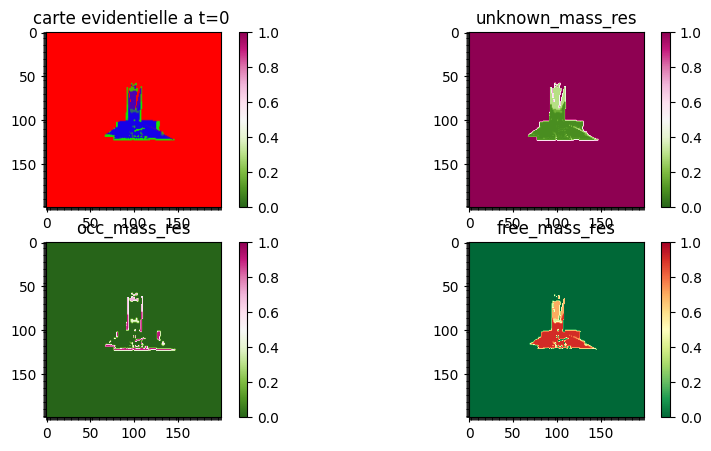

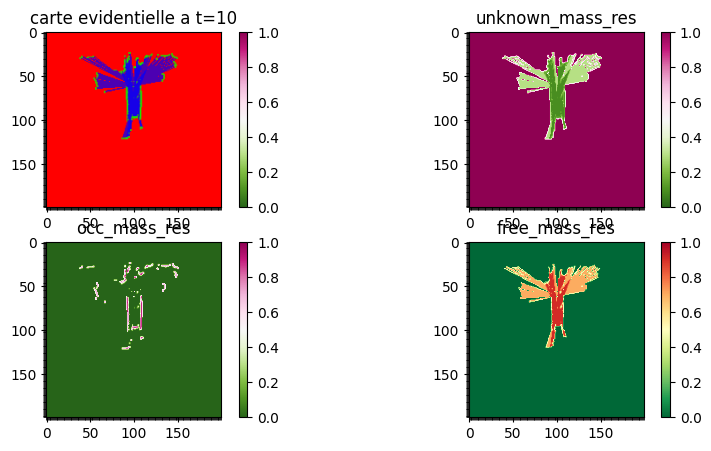

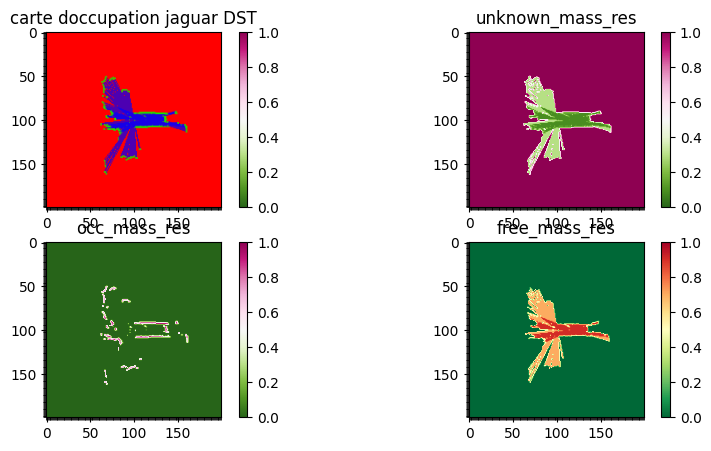

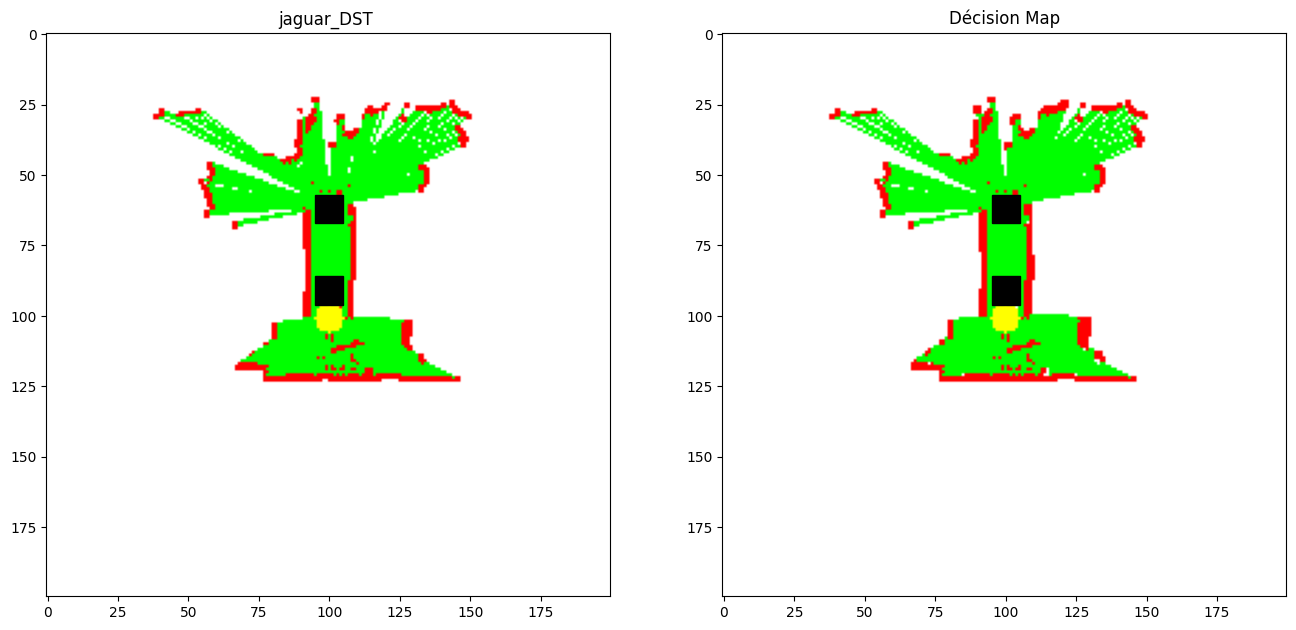

In [107]:

#Enregistrement et affichage des cartes
#la visualisation de dgm1 : première carte d'occupation jaguar
carte_11 = dgm1[:, :, 0:1]
carte_12 = dgm1[:, :, 1:2]
carte_13 = dgm1[:, :, 2:3]

plt.figure(figsize=(10, 5))

plt.subplot(2,2 , 1)
plt.imshow(dgm1, cmap="PiYG_r")
plt.title('carte evidentielle a t=0 ')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="r", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(carte_11[:, :, 0], cmap="PiYG_r")
plt.title('unknown_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(carte_12[:, :, 0], cmap="PiYG_r")
plt.title('occ_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.5, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(carte_13[:, :, 0], cmap="RdYlGn_r")
plt.title('free_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.8, alpha=0)
plt.colorbar()


#la visualisation de dgm2 : deuxième carte d'occupation
carte_21 = dgm2[:, :, 0:1]
carte_22 = dgm2[:, :, 1:2]
carte_23 = dgm2[:, :, 2:3]

plt.figure(figsize=(10, 5))

plt.subplot(2,2 , 1)
plt.imshow(dgm2, cmap="PiYG_r")
plt.title('carte evidentielle a t=10')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="r", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(carte_21[:, :, 0], cmap="PiYG_r")
plt.title('unknown_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(carte_22[:, :, 0], cmap="PiYG_r")
plt.title('occ_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.5, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(carte_23[:, :, 0], cmap="RdYlGn_r")
plt.title('free_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.8, alpha=0)
plt.colorbar()




#la visualisation de dgm3 : Troisiéme carte d'occupation fusion DST
xy_res = np.array(dgm3).shape
carte_1 = dgm3[:, :, 0:1]
carte_2 = dgm3[:, :, 1:2]
carte_3 = dgm3[:, :, 2:3]



plt.figure(figsize=(10, 5))
plt.subplot(2,2 , 1)
plt.imshow(dgm3, cmap="PiYG_r")
plt.title('carte doccupation jaguar DST')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="r", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(carte_1[:, :, 0], cmap="PiYG_r")
plt.title('unknown_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(carte_2[:, :, 0], cmap="PiYG_r")
plt.title('occ_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.5, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(carte_3[:, :, 0], cmap="RdYlGn_r")
plt.title('free_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.8, alpha=0)
plt.colorbar()




rect_params = {'width': 10, 'height': 10, 'edgecolor': 'black', 'facecolor': 'black'}
triangle_vertices = np.array([[94, 88],[100, 95], [106, 88] ])
triangle = Polygon(triangle_vertices, closed=True, edgecolor='black', facecolor='black')
triangle_vertices1 = np.array([[94, 62], [100, 69],[106, 62]])
triangle1 = Polygon(triangle_vertices1, closed=True, edgecolor='black', facecolor='black')
triangle_vertices2 = np.array([[119, 98], [122, 99],[119, 100] ])
triangle1 = Polygon(triangle_vertices1, closed=True, edgecolor='black', facecolor='black')

fig,axs = plt.subplots(1,2,figsize=(16,8))
center = (100,100)
cv2.circle(dgm_pred,tuple(center[:2]),3,(255,255,0),-1)
cv2.circle(decision,tuple(center[:2]),3,(255,255,0),-1)
axs[0].add_patch(Rectangle((95, 86), **rect_params))
axs[0].add_patch(Rectangle((95, 57), **rect_params))
axs[0].set_title('jaguar_DST ')
axs[0].imshow(((dgm_pred)))
axs[1].add_patch(Rectangle((95, 86), **rect_params))
axs[1].add_patch(Rectangle((95, 57), **rect_params))
axs[1].imshow(decision)
axs[1].set_title('Décision Map')



plt.show()
#np.save('./ev_occ_jag_dst.npy', dgm3)


# ***Carte d'occupation globale du segway : Fusion DST/Conjonctive:***

Ce code prend des cartes d'occupation provenant du robot SEGWAY, les transforme dans un repère commun, les fusionne en utilisant la DST ou la fusion conjonctive, enregistre les décisions de fusion dans un fichier CSV, et enregistre la carte d'occupation fusionnée. Il fournit également des visualisations pour faciliter la compréhension des résultats.

Voici une description générale de ce que fait le code :

- **Chargement des cartes d'occupation** : Le code commence par charger des cartes d'occupation à partir de fichiers .npy dans un dossier spécifié. La fonction charger_cartes_occupation parcourt les fichiers .npy dans le dossier et les charge à l'aide de NumPy.

- **Chargement des poses des robots** : Les poses des Robots(jaguar et segway) sont préalablement définies manuellement ou chargées à partir d'un fichier CSV. Ces poses sont utilisées pour effectuer des transformations sur les cartes d'occupation.

- **Transformation des poses et des cartes d'occupation** : Les poses des véhicules sont utilisées pour transformer les cartes d'occupation dans un repère de référence commun. Cela permet de superposer les cartes d'occupation de manière cohérente pour effectuer des comparaisons ou des fusions.

- **Fusion de deux cartes d'occupation** : Les cartes d'occupation sont fusionnées en utilisant la théorie de Dempster-Shafer Theory (DST) ou la fusion Conjonctive. Cette fusion prend en compte les masses conflictuelles, libres, occupées et inconnues dans chaque cellule des cartes d'occupation pour produire une nouvelle carte résultante.

- **Enregistrement des décisions dans un fichier CSV** : Les décisions résultantes de la fusion des cartes d'occupation sont enregistrées dans un fichier CSV.

- **Visualisation des cartes d'occupation et des décisions** : Les cartes d'occupation originales, les cartes transformées, les décisions de fusion et d'autres informations sont visualisées à l'aide de bibliothèques telles que Matplotlib et OpenCV.

- **Enregistrement de la carte fusionnée** : La carte d'occupation résultante après la fusion est enregistrée au format .npy.



Lien de base de données : https://drive.google.com/drive/folders/1npBoFebg8iXZyWqe0n0zADYeMIY1_OWp?usp=sharing

1- **Chargement des cartes d'occupation** : Le code commence par charger des cartes d'occupation à partir de fichiers .npy dans un dossier spécifié. La fonction charger_cartes_occupation parcourt les fichiers .npy dans le dossier et les charge à l'aide de NumPy.

In [86]:
dgm_file_path = '/content/drive/MyDrive/Data/ev_occ_SEG1701090674.06131.npy'
dgm_file_path1 = '/content/drive/MyDrive/Data/ev_occ_SEG1701090680.4164743.npy'
dgm1 = np.load(dgm_file_path)
dgm2 = np.load(dgm_file_path1)


2- **Chargement des poses des robots** : Les poses des Robots(jaguar et segway) sont préalablement définies manuellement ou chargées à partir d'un fichier CSV. Ces poses sont utilisées pour effectuer des transformations sur les cartes d'occupation.

In [87]:
#Charger les poses
translation_jaguar = [1.6768008242702426, -1.0237042776426992, 0.4376076507983792]
rotation_jaguar =  [0.00021718878130072672, -0.0035360931187846736, 0.9995646244043541, -0.02929181650002164]
#print('jaguarpose',translation_jaguar,rotation_jaguar)
translation_segway = [-0.8695310124594807, -0.9703839553078375, 0.47057253638676794]
rotation_segway =[-0.0030003582503948913, -0.0032650469112049745, 0.9993261088497013, -0.036437144377020864]
#print('segpose',rotation_segway, translation_segway)
pose_jaguar = load_vehicle_pose_vel(rotation_jaguar, translation_jaguar)
pose_seg = load_vehicle_pose_vel(rotation_segway, translation_segway)

3- **Transformation des poses et des cartes d'occupation** : Les poses des véhicules sont utilisées pour transformer les cartes d'occupation dans un repère de référence commun. Cela permet de superposer les cartes d'occupation de manière cohérente pour effectuer des comparaisons ou des fusions.

In [88]:
#Fonction pour faire la transformation de pose
def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  theta = init[2] /180 * np.pi
  #theta = -init[2]
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]+2.65],[init[1]+1.8]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=1)
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),-delta_theta  ,1)
  #M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  return dst

shifted_dgm = shift_pose_dgm(dgm2 ,pose_seg ,pose_jaguar)

4- **Fusion de deux cartes d'occupation** : Les cartes d'occupation sont fusionnées en utilisant la théorie de Dempster-Shafer Theory (DST). Cette fusion prend en compte les masses conflictuelles, libres, occupées et inconnues dans chaque cellule des cartes d'occupation pour produire une nouvelle carte résultante.

In [89]:
#Fonction pour fusionner deux carte avec DST
def update_dgm(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))
  #conflict_mass = 0
  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)
  ### calculer les probabilités
  betPF = free_mass + 0.5* unknown_mass
  betpO = occ_mass + 0.5* unknown_mass

  updated_dgm1 = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  map_decision = np.stack((betPF, betpO),axis=2)

  return updated_dgm1,conflict_mass, map_decision



#Fonction pour fusionner deux carte en utilisant la fusion conjonctive
def update_dgm_conjonctive(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))
  #conflict_mass = 0
  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])

  ### calculer les probabilités
  betPF = free_mass + 0.5* unknown_mass
  betpO = occ_mass + 0.5* unknown_mass

  updated_dgm1 = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  map_decision = np.stack((betPF, betpO),axis=2)

  return updated_dgm1,conflict_mass, map_decision


dgm3,dynamic_mass ,map_decision1 = update_dgm(shifted_dgm, dgm1  )

In [90]:

#Fonction pour afficher la carte d'occupation statique
def predict_dgm1(dgm):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)

  # The unknown cells: gray
  pred_map[max_mass==0] = (255,255,255)

  # The occupied cells: black
  pred_map[max_mass==1] = (255,0,0)

  # The free cells: white
  pred_map[max_mass==2] = (0,255,0)

  # The dynamic cells: blue
  #pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)



#Fonction pour afficher la carte d'occupation dynamique
def predict_dgm(dgm):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)

  # The unknown cells: gray
  pred_map[max_mass==0] = (255,255,255)

  # The occupied cells: black
  pred_map[max_mass==1] = (255,0,0)

  # The free cells: white
  pred_map[max_mass==2] = (0,255,0)

  # The dynamic cells: blue
  pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)


dgm_pred = predict_dgm(dgm3)
dgm_tiago = predict_dgm1(dgm1)
dgm_seg = predict_dgm1(dgm2)


5- **Carte de décision** : Une carte de décision est générée en comparant les probabilités de présence des obstacles et des zones libres.


In [91]:
#Fonction pour la creation des cartes de la décision
def decision_map(dgm,map_array):
    new_map = np.zeros(dgm.shape)

    P1 = map_array[:, :, 0]
    P2 = map_array[:, :, 1]

    new_map[P1 < P2] = (255,0,0)
    new_map[P1 > P2] = (0,255,0)
    new_map[P1 == P2] = (252,123,123)

    return new_map

decision = decision_map(dgm2,map_decision1)



5- **Visualisation des cartes d'occupation et des décisions** : Les cartes d'occupation originales, les cartes transformées, les décisions de fusion et d'autres informations sont visualisées à l'aide de bibliothèques telles que Matplotlib et OpenCV.

6- **Enregistrement de la carte fusionnée** : La carte d'occupation résultante après la fusion est enregistrée au format .npy.

7- **Enregistrement des décisions dans un fichier CSV** : Les décisions résultantes de la fusion des cartes d'occupation sont enregistrées dans un fichier CSV.

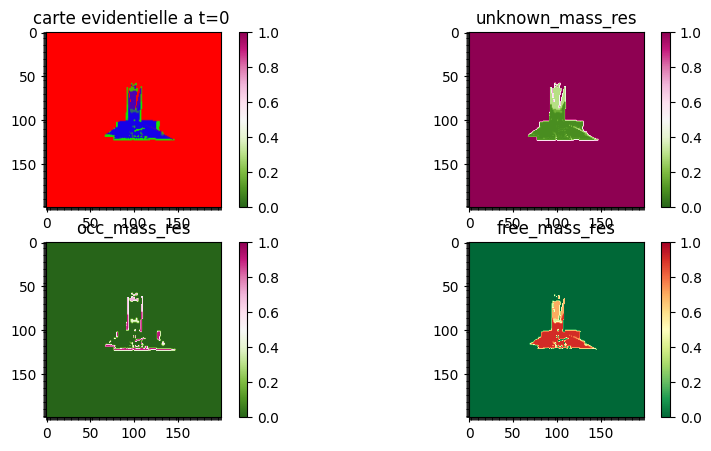

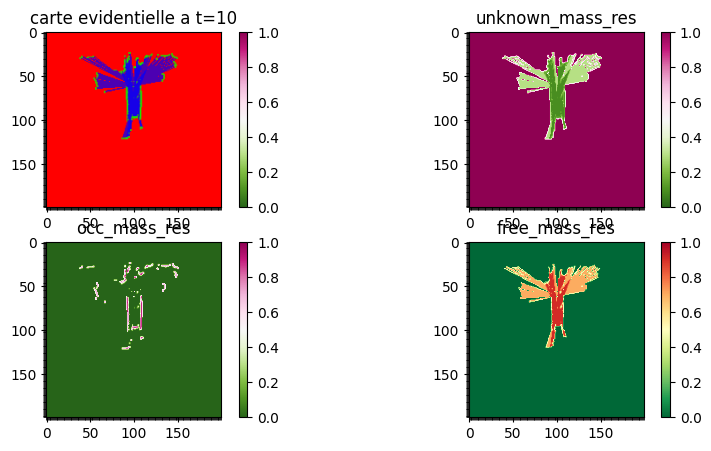

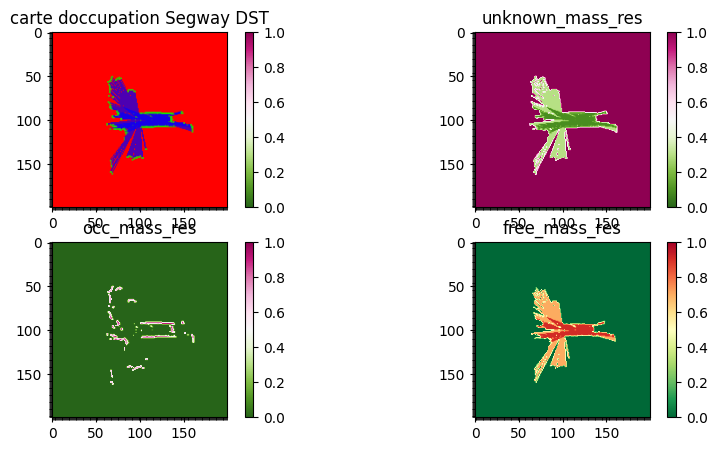

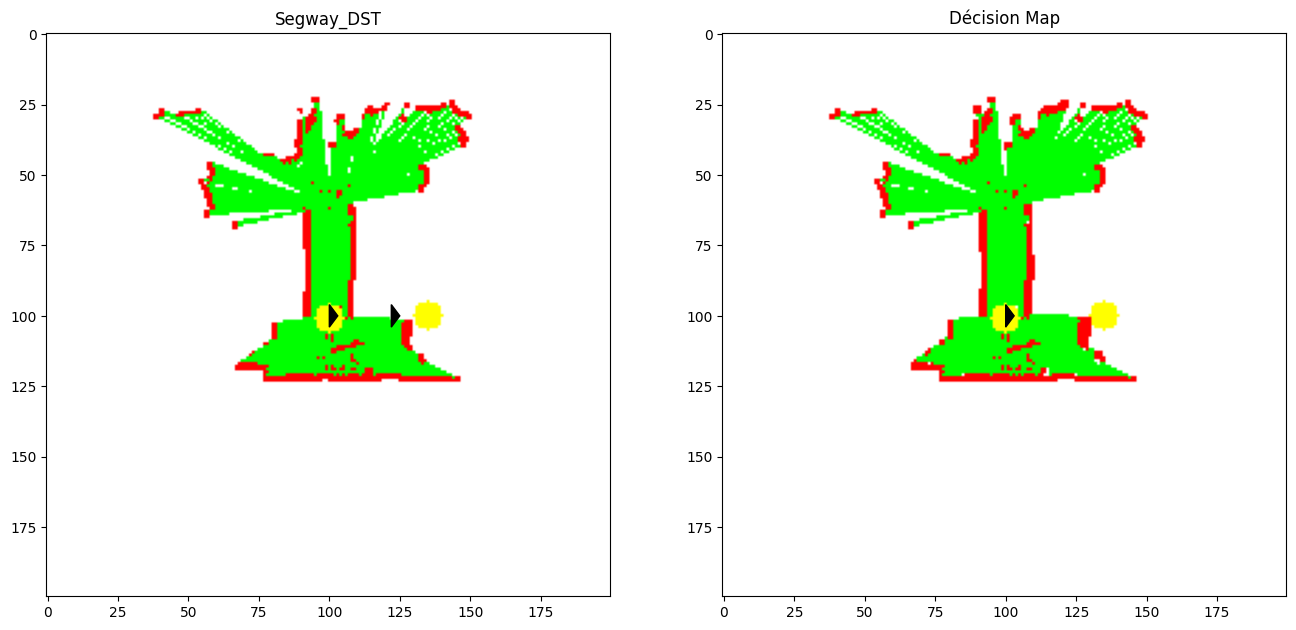

In [108]:

triangle_vertices = np.array([[100, 96], [100, 104], [103, 100]])
triangle = Polygon(triangle_vertices, closed=True, edgecolor='black', facecolor='black')

triangle_vertices1 = np.array([[100, 96], [100, 104], [103, 100]])
triangle1 = Polygon(triangle_vertices1, closed=True, edgecolor='black', facecolor='black')

triangle_vertices2 = np.array([[122, 96], [122, 104], [125, 100]])
triangle2 = Polygon(triangle_vertices2, closed=True, edgecolor='black', facecolor='black')

triangle_vertices3 = np.array([[99, 95], [99, 103], [102, 99]])
triangle3 = Polygon(triangle_vertices3, closed=True, edgecolor='black', facecolor='black')


#Enregistrement et affichage des cartes
#Visualisation de dgm1 : première carte d'occupation Segway
carte_11 = dgm1[:, :, 0:1]
carte_12 = dgm1[:, :, 1:2]
carte_13 = dgm1[:, :, 2:3]

plt.figure(figsize=(10, 5))

plt.subplot(2,2 , 1)
plt.imshow(dgm1, cmap="PiYG_r")
plt.title('carte evidentielle a t=0 ')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="r", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(carte_11[:, :, 0], cmap="PiYG_r")
plt.title('unknown_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(carte_12[:, :, 0], cmap="PiYG_r")
plt.title('occ_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.5, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(carte_13[:, :, 0], cmap="RdYlGn_r")
plt.title('free_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.8, alpha=0)
plt.colorbar()

#Visualisation de dgm2 : deuxième carte d'occupation Segway
carte_21 = dgm2[:, :, 0:1]
carte_22 = dgm2[:, :, 1:2]
carte_23 = dgm2[:, :, 2:3]

plt.figure(figsize=(10, 5))

plt.subplot(2,2 , 1)
plt.imshow(dgm2, cmap="PiYG_r")
plt.title('carte evidentielle a t=10')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="r", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(carte_21[:, :, 0], cmap="PiYG_r")
plt.title('unknown_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(carte_22[:, :, 0], cmap="PiYG_r")
plt.title('occ_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.5, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(carte_23[:, :, 0], cmap="RdYlGn_r")
plt.title('free_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.8, alpha=0)
plt.colorbar()



#Visualisation de dgm3 : Troisiéme carte d'occupation Segway DST

xy_res = np.array(dgm3).shape
carte_1 = dgm3[:, :, 0:1]
carte_2 = dgm3[:, :, 1:2]
carte_3 = dgm3[:, :, 2:3]

plt.figure(figsize=(10, 5))
plt.subplot(2,2 , 1)
plt.imshow(dgm3, cmap="PiYG_r")
plt.title('carte doccupation Segway DST')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="r", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(carte_1[:, :, 0], cmap="PiYG_r")
plt.title('unknown_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(carte_2[:, :, 0], cmap="PiYG_r")
plt.title('occ_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.5, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(carte_3[:, :, 0], cmap="RdYlGn_r")
plt.title('free_mass_res')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.8, alpha=0)
plt.colorbar()


fig,axs = plt.subplots(1,2,figsize=(16,8))
center = (135,100)
cv2.circle(dgm_pred,tuple(center[:2]),5,(255,255,0),-1)
cv2.circle(decision,tuple(center[:2]),5,(255,255,0),-1)

axs[0].add_patch(Polygon(np.array(triangle_vertices2), closed=True, edgecolor='black', facecolor='black'))
axs[0].add_patch(Polygon(np.array(triangle_vertices1), closed=True, edgecolor='black', facecolor='black'))


axs[0].set_title('Segway_DST')
axs[0].imshow(((dgm_pred)))
axs[1].add_patch(Polygon(np.array(triangle_vertices1), closed=True, edgecolor='black', facecolor='black'))
axs[1].imshow(decision)
axs[1].set_title('Décision Map')

plt.show()

# ***Carte d'occupation globale du segway et jaguar : Fusion DST/Conjonctive:***

Ce code prend en entrée des cartes d'occupation et des poses de robots SEGWAY et JAGUAR, les fusionne pour prendre des décisions sur l'environnement, et fournit des visualisations ainsi que des données enregistrées. Voici un résumé de ce que fait le code :

- **Chargement des cartes d'occupation** : Deux cartes d'occupation sont chargées à partir de fichiers numpy.


- **Transformation de poses** : Des fonctions sont définies pour extraire les poses des véhicules à partir de matrices de rotation et de translation, ainsi que pour effectuer des transformations sur ces poses.

- **Fusion des cartes d'occupation DST** : Une fonction est définie pour fusionner deux cartes d'occupation en calculant les masses conflictuelles, libres, occupées et inconnues.

- **Visualisation des cartes d'occupation** : Les cartes d'occupation fusionnées ainsi que les cartes individuelles pour les masses libre, occupée et inconnue sont visualisées.

- **Carte de décision** : Une carte de décision est générée en comparant les probabilités de présence des obstacles et des zones libres.

- **Visualisation de la carte de décision** : La carte de décision est visualisée, montrant les zones prédites comme libres, occupées ou incertaines.

- **Enregistrement des valeurs de la carte de décision** : Les valeurs de la carte de décision sont enregistrées dans un fichier CSV.


Lien de base de données : https://drive.google.com/drive/folders/1npBoFebg8iXZyWqe0n0zADYeMIY1_OWp?usp=sharing

1-  **Chargement des cartes d'occupation** : Deux cartes d'occupation sont chargées à partir de fichiers numpy.

In [93]:
#Chargement des cartes d'occupation

dgm_file_path3 = '/content/drive/MyDrive/Data/ev_occ_jag_dst.npy'
dgm_file_path4 = '/content/drive/MyDrive/Data/ev_occ_seg_dst.npy'
dgm1 = np.load(dgm_file_path3)
dgm2 = np.load(dgm_file_path4)

2- **Chargement des poses** : Extraction des données de translation et de rotation à partir d'un fichier CSV et les convertit en matrices numpy

In [94]:

def read_pose_csv(csv_file):
    # Lire le fichier CSV en utilisant pandas
    df = pd.read_csv(csv_file)

    # Extraire les colonnes de translation et de rotation
    translations = df['Translation'].apply(eval).tolist()
    rotations = df['Rotation'].apply(eval).tolist()

    # Convertir les listes en tableaux numpy
    translation_matrix = np.array(translations)
    rotation_matrix = np.array(rotations)

    return translation_matrix, rotation_matrix

#csv_file_jaguar = "output_matrices_1700563331.907.csv"  # Replace with your CSV file path
#translation_jaguar, rotation_jaguar = read_pose_csv(csv_file_jaguar)
translation_jaguar = [1.6768008242702426, -1.0237042776426992, 0.4376076507983792]
rotation_jaguar =  [0.00021718878130072672, -0.0035360931187846736, 0.9995646244043541, -0.02929181650002164]
#print('jaguarpose',translation_jaguar,rotation_jaguar)
#csv_file_segway = "output_matrices_1700563331.907.csv"  # Replace with your CSV file path
#translation_segway, rotation_segway = read_pose_csv(csv_file_segway)
translation_segway = [-0.8695310124594807, -0.9703839553078375, 0.47057253638676794]
rotation_segway =[-0.0030003582503948913, -0.0032650469112049745, 0.9993261088497013, -0.036437144377020864]
#print('segpose',rotation_segway, translation_segway)
pose_jaguar =(0,0,0)# load_vehicle_pose_vel(rotation_jaguar, translation_jaguar)
pose_seg =(0,0,0)# load_vehicle_pose_vel(rotation_segway, translation_segway)




3- **Transformation de poses** : Des fonctions sont définies pour extraire les poses des véhicules à partir de matrices de rotation et de translation, ainsi que pour effectuer des transformations sur ces poses.


In [95]:
#Fonction pour avoir une pose sous la forme(x,y,yaw)
def load_vehicle_pose_vel(rotation_pose, translation_pose):

    translation = translation_pose
    rotation = rotation_pose
    # extract x and y from translation vector
    x = translation[0]
    y = translation[1]
    print(x,y)

    x1, y1, z, w = rotation

    # Calculer le yaw (angle de lacet)
    yaw = np.arctan2(2 * (w * z + x1 * y), 1 - 2 * (y1**2 + z**2))
    print(yaw)

    return (x, y, yaw)

#Décalage de la carte d'occupation
dgm2 = cv2.rotate(dgm2,cv2.ROTATE_90_CLOCKWISE)
#dgm2 = cv2.rotate(dgm2, cv2.ROTATE_90_COUNTERCLOCKWISE)
#dgm2 = cv2.rotate(dgm2, cv2.ROTATE_180)
new_center = (103,102)
# Nouveau centre
old_center = (102, 141)

# Calcul du décalage en termes d'indices de tableau
shift_x = new_center[0] - old_center[0]
shift_y = new_center[1] - old_center[1]

# Appliquer le décalage à la carte d'occupation
dgm2 = np.roll(dgm2, shift_y, axis=0)
dgm2 = np.roll(dgm2, shift_x, axis=1)

In [96]:
#Fonction pour faire la transformation de pose

def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  theta = init[2] /180 * np.pi
  #theta = -init[2]
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=1)
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),-delta_theta  ,1)
  #M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=1)
  return dst


4- **Fusion des cartes d'occupation** : Une fonction est définie pour fusionner deux cartes d'occupation en calculant les masses conflictuelles, libres, occupées et inconnues.

In [97]:
#Fonction pour fusionner deux carte avec DST
def update_dgm(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))
  #conflict_mass = 0
  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)

  ### calcule les probabilités
  betPF = free_mass + 0.5* unknown_mass
  betpO = occ_mass + 0.5* unknown_mass

  updated_dgm1 = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  map_decision = np.stack((betPF, betpO),axis=2)

  return updated_dgm1,conflict_mass, map_decision


#Fonction pour fusionner deux carte en utilisant la fusion conjonctive
def update_dgm_conjonctive(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))

  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])

  ### calcule les probabilités
  betPF = free_mass + 0.5* unknown_mass
  betpO = occ_mass + 0.5* unknown_mass

  updated_dgm1 = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  map_decision = np.stack((betPF, betpO),axis=2)

  return updated_dgm1,conflict_mass, map_decision


dgm4,dynamic_mass ,map_decision1 = update_dgm(dgm1, dgm2  )
print('dgm est', dgm4.shape)
#print('conflit', dynamic_mass)
xy_res = np.array(dgm4).shape

dgm est (200, 200, 3)




5- **Carte de décision** : Une carte de décision est générée en comparant les probabilités de présence des obstacles et des zones libres.



In [98]:

# Affichage de la carte d'occupation Statique
def predict_dgm1(dgm):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)

  # The unknown cells: gray
  pred_map[max_mass==0] = (255,255,255)

  # The occupied cells: black
  pred_map[max_mass==1] = (255,0,0)

  # The free cells: white
  pred_map[max_mass==2] = (0,255,0)

  # The dynamic cells: blue
  #pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)


# Affichage de la carte d'occupation dynamique
def predict_dgm(dgm):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)

  # The unknown cells: gray
  pred_map[max_mass==0] = (255,255,255)

  # The occupied cells: black
  pred_map[max_mass==1] = (255,0,0)

  # The free cells: white
  pred_map[max_mass==2] = (0,255,0)

  # The dynamic cells: blue
  pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)

dgm_pred = predict_dgm(dgm4)
dgm_tiago = predict_dgm1(dgm1)
dgm_seg = predict_dgm1(dgm2)


#visualisation de la carte de la décision
def decision_map(dgm,map_array):
    new_map = np.zeros(dgm.shape)

    P1 = map_array[:, :, 0]
    P2 = map_array[:, :, 1]

    new_map[P1 < P2] = (255,0,0)
    new_map[P1 > P2] = (0,255,0)
    new_map[P1 == P2] = (255,255,255)

    return new_map


decision = decision_map(dgm2,map_decision1)

6- **Visualisation des cartes d'occupation** : Les cartes d'occupation fusionnées ainsi que les cartes individuelles pour les masses libre, occupée et inconnue sont visualisées.




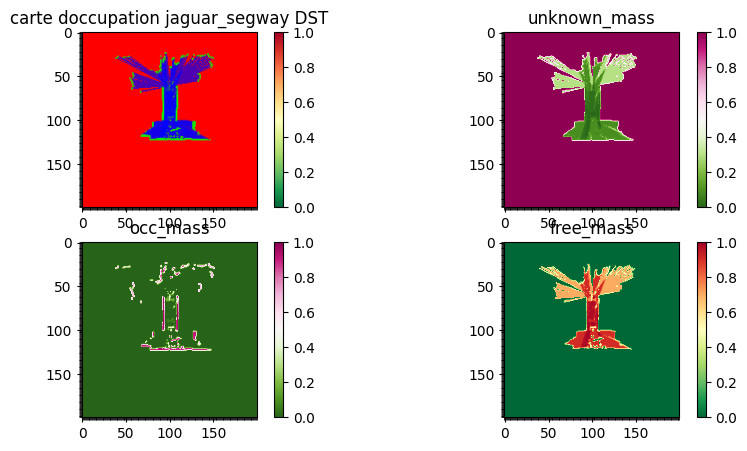

In [99]:
# Extraction et visualisation des trois cartes de taille (la carte globale, liberté, occupation, ignorance)(200, 200, 1)
carte_1 = dgm4[:, :, 0:1]
carte_2 = dgm4[:, :, 1:2]
carte_3 = dgm4[:, :, 2:3]

plt.figure(figsize=(10, 5))

plt.subplot(2,2 , 1)
plt.imshow(dgm4, cmap="RdYlGn_r")
plt.title('carte doccupation jaguar_segway DST')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(carte_1[:, :, 0], cmap="PiYG_r")
plt.title('unknown_mass')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="b", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(carte_2[:, :, 0], cmap="PiYG_r")
plt.title('occ_mass')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="major", color="r", linewidth=0.2, alpha=0)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(carte_3[:, :, 0], cmap="RdYlGn_r")
plt.title('free_mass')
plt.clim(0, 1)
plt.gca().set_xticks(np.arange(-.5, xy_res[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, xy_res[0], 1), minor=True)
plt.grid(True, which="minor", color="b", linewidth=0.2, alpha=0)
plt.colorbar()
plt.savefig("seg_jaguar_maps.png", bbox_inches="tight")


# Vérification des dimensions des nouvelles cartes
#print(carte_1.shape)  # Devrait afficher (200, 200, 1)
#print(carte_2.shape)  # Devrait afficher (200, 200, 1)
#print(carte_3.shape)  # Devrait afficher (200, 200, 1)


7- **Visualisation de la carte de décision** : La carte de décision est visualisée, montrant les zones prédites comme libres, occupées ou incertaines.

8- **Enregistrement des valeurs de la carte de décision** : Les valeurs de la carte de décision sont enregistrées dans un fichier CSV.

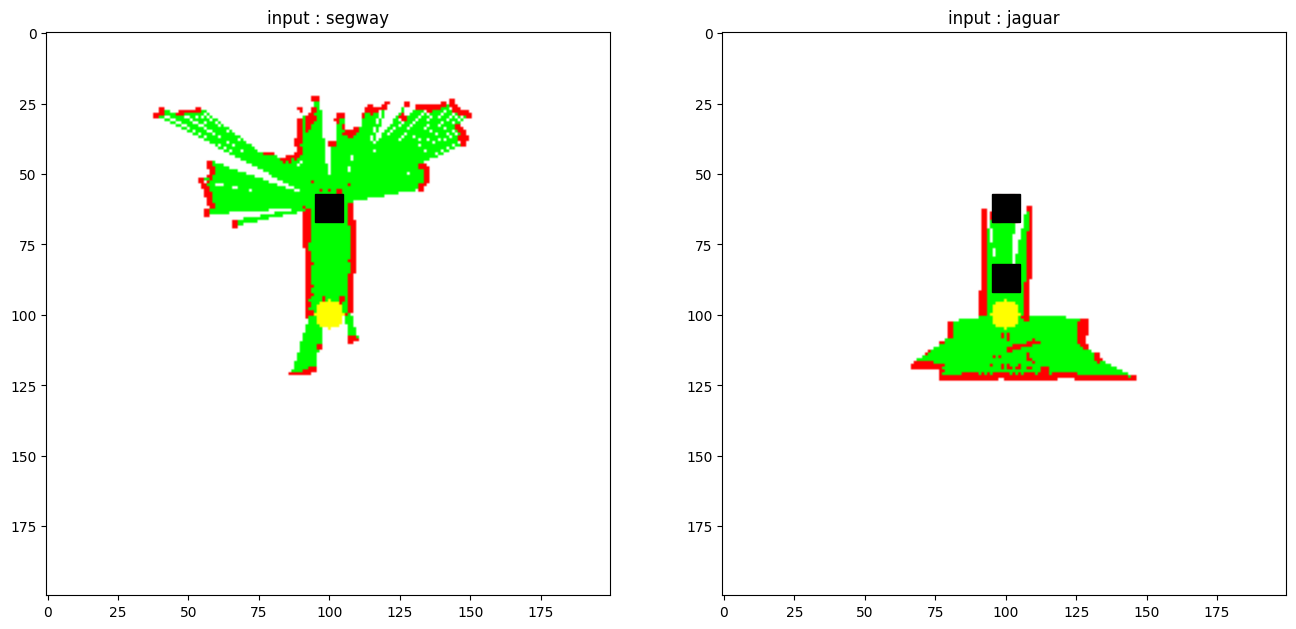

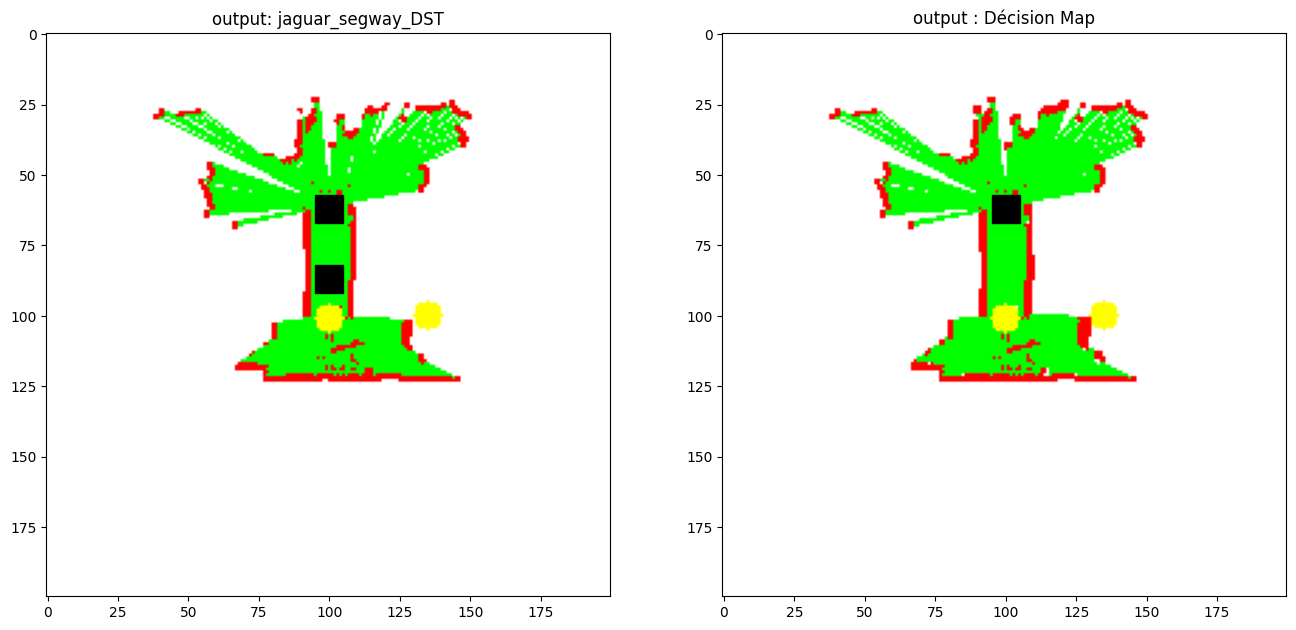

In [109]:

#Visualisation des cartes d'occupation
triangle_vertices = np.array([[94, 88],[100, 95], [106, 88] ])
triangle = Polygon(triangle_vertices, closed=True, edgecolor='black', facecolor='black')
triangle_vertices1 = np.array([[94, 62], [100, 69],[106, 62]])
triangle1 = Polygon(triangle_vertices1, closed=True, edgecolor='black', facecolor='black')
triangle_vertices2 = np.array([[119, 98], [122, 99],[119, 100] ])
triangle1 = Polygon(triangle_vertices1, closed=True, edgecolor='black', facecolor='black')
rect_params = {'width': 10, 'height': 10, 'edgecolor': 'black', 'facecolor': 'black'}

fig,axs = plt.subplots(1,2,figsize=(16,8))
center1 = (100,100)
center2 = (100,100)
cv2.circle(dgm_seg,tuple(center2[:2]),5,(255,255,0),-1)
cv2.circle(dgm_tiago,tuple(center1[:2]),5,(255,255,0),-1)
axs[0].add_patch(Rectangle((95, 57), **rect_params))
axs[0].imshow(((dgm_seg)))
axs[1].add_patch(Rectangle((95, 82), **rect_params))
axs[1].add_patch(Rectangle((95, 57), **rect_params))
axs[1].imshow(dgm_tiago)
axs[0].set_title('input : segway')
axs[1].set_title('input : jaguar')

fig,axs = plt.subplots(1,2,figsize=(16,8))
center = (100,101)
cv2.circle(dgm_pred,tuple(center[:2]),5,(255,255,0),-1)
cv2.circle(decision,tuple(center[:2]),5,(255,255,0),-1)
rect_params = {'width': 10, 'height': 10, 'edgecolor': 'black', 'facecolor': 'black'}
axs[0].add_patch(Rectangle((95, 82), **rect_params))
axs[0].add_patch(Rectangle((95, 57), **rect_params))
axs[0].set_title('output: jaguar_segway_DST')
axs[0].imshow(((dgm_pred)))
axs[1].add_patch(Rectangle((95, 57), **rect_params))
axs[1].imshow(decision)
axs[1].set_title('output : Décision Map')




#Enregistrement des valeurs de la carte de la décision

# Chemin du fichier CSV à créer ou à écrire
#fichier_csv = "tableau.csv"

# Écrire dans le fichier CSV
#with open(fichier_csv, 'w', newline='') as fichier:
#    writer = csv.writer(fichier)
#    writer.writerows(map_decision1)

#image_filename = "/home/mahmoud/Bureau/res1/image146.png"
#axs[0].get_figure().savefig(image_filename, bbox_inches='tight', pad_inches=0.1)


plt.show()

## REFERENCES

[1] Référentiel pour le tutoriel : https://github.com/MukhlasAdib/KITTI_Mapping.

[2] Référentiel pour le tutoriel: https://atsushisakai.github.io/PythonRobotics/modules/mapping/lidar_to_grid_map_tutorial/lidar_to_grid_map_tutorial.html

[3] Grilles de perception évidentielles pour la navigation
robotique en milieu urbain Julien Moras : https://theses.hal.science/tel-00866300v1/document

